In [1]:
import sys

not ".." in sys.path and sys.path.insert(0, "..")

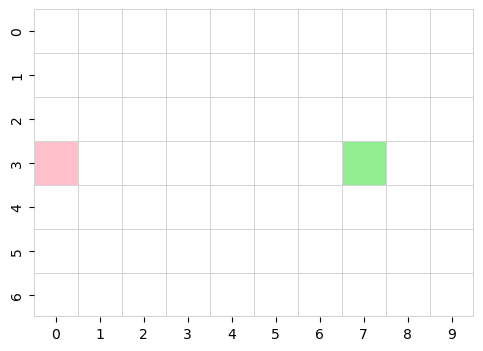

In [2]:
import numpy as np
from chapter_6.windy_gridworld import WindyGridWorld, sample_policy_episode


np.random.seed(42)

grid_world = WindyGridWorld()
grid_world.render()


Ep #19980: 13 time steps. Convergence rate: 98.16%: 100%|██████████| 20000/20000 [00:29<00:00, 681.74it/s]


Convergence rate: 98.25%


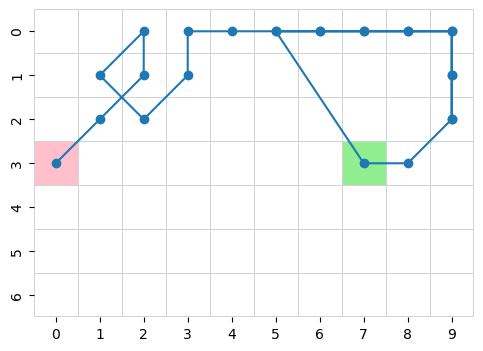

In [3]:
import logging
from tqdm import trange


def n_step_sarsa(
    env: WindyGridWorld,
    max_eps: int = 100,
    max_time: int = 20000,
    n=4,
    alpha=0.5,
    epsilon=0.1,
    discount=1,
):
    logging.info("Start training...")
    # Inititalize
    action_dim = len(env.action_space)
    state_action_dims = (*env.grid_map.shape, action_dim)
    Q = -max_time * np.ones(state_action_dims)
    policy = np.ones(Q.shape) / action_dim

    temp_S = np.full(n + 1, None)
    temp_A = np.full(n + 1, None)
    temp_R = np.zeros(n + 1)

    def choose_action(state: tuple):
        return np.random.choice(action_dim, p=policy[state])

    state_history = [env.current_state]
    progress_bar = trange(max_eps)
    converged_count = 0
    for ep_num in progress_bar:
        env.reset()
        state = tuple(env.current_state)
        action = choose_action(state)
        temp_S[0] = state
        temp_A[0] = action
        T = max_time

        state_history = [env.current_state]
        for t in range(max_time):
            temp_idx = (t + 1) % (n + 1)
            if t < T:
                reward, finished = env.step(env.action_space[action])
                next_state = tuple(env.current_state)

                temp_S[temp_idx] = next_state
                temp_R[temp_idx] = reward

                if finished:
                    T = t + 1
                    converged_count += 1
                    if ep_num % 20 == 0:
                        progress_bar.set_description(f"Ep #{ep_num}: {t} time steps. Convergence rate: {round(converged_count * 100 / max_eps, 2)}%")
                else:
                    next_action = choose_action(next_state)
                    temp_A[temp_idx] = next_action
            
            tau = t - n + 1
            if tau >= 0:
                G = sum([
                    np.power(discount, i - tau - 1) * temp_R[i % (n + 1)]
                    for i in range(tau + 1, min(tau + n, int(T)))
                ])
                if tau + n < T:
                    idx = (tau + n) % (n + 1)
                    next_state_action = (*temp_S[idx], temp_A[idx])
                    G += (discount ** n) * Q[next_state_action]

                idx = tau % (n + 1)
                state_action = (*temp_S[idx], temp_A[idx])
                Q[state_action] += alpha * (G - Q[state_action])

                # Ensure policy is epsilon-greedy wrt to Q
                policy[temp_S[idx]] = epsilon / action_dim
                policy[(*temp_S[idx], np.argmax(Q[temp_S[idx]]))] = 1 - epsilon + epsilon / action_dim

            state = temp_S[temp_idx]
            action = temp_A[temp_idx]
            state_history.append(state)

            if tau == T - 1:
                break

    print(f"Convergence rate: {round(converged_count * 100 / max_eps, 2)}%")
    env.render(state_history)
    policy = np.argmax(Q, axis=-1)
    return Q, policy


Q, policy = n_step_sarsa(grid_world, max_eps=20000, max_time=50, n=8, epsilon=0.1, alpha=0.1)

[[ 1  0]
 [-1  0]
 [ 0  1]
 [-1 -1]
 [ 1  1]
 [-1  1]
 [ 0  0]
 [ 0 -1]
 [ 1 -1]]
[[5 5 8 2 4 2 4 2 2 4]
 [3 4 5 1 6 2 5 7 4 0]
 [5 5 5 5 1 2 2 4 2 8]
 [5 7 0 5 8 3 0 0 8 5]
 [2 4 4 5 4 6 0 0 6 0]
 [2 0 4 2 5 2 0 3 8 7]
 [2 4 5 2 4 7 0 0 0 0]]


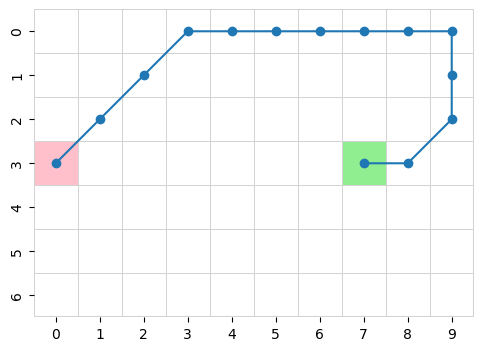

In [4]:
sample_policy_episode(grid_world, policy, 15)
print(grid_world.action_space)
print(policy)